# Code to train the RL agent

This code trains a PPO [stablebaseline3 RL-agent](https://github.com/DLR-RM/stable-baselines3) to learn an ideal policy to decide when to allow the student to use GenAI

## Imports

In [216]:
#imports 
from environment import LearningEnv     # your environment file
from gymnasium.envs.registration import register
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.monitor import Monitor
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

## 1. Register the custom environment

In [217]:
register(
    id="MyEnv-v1",
    entry_point="environment:LearningEnv",
)

## 2. Create and check the environment

In [218]:
env = gym.make("MyEnv-v1")
check_env(env)        #recommended by stable-baselines3 for custom envs
env = Monitor(env)    #logs rewards, episode lengths, etc.

In [219]:
print("Observation Space:", env.observation_space)
print("Observation Shape:", env.observation_space.shape)
print("Observation Dtype:", env.observation_space.dtype)
print("High bounds:", env.observation_space.high)

# 2. Check Output (Action) Details
print("Action Space:", env.action_space)
if isinstance(env.action_space, gym.spaces.Discrete):
    print("Number of discrete actions:", env.action_space.n)

Observation Space: Box(0.0, [2.e+01 1.e+04 6.e+01 1.e+00 1.e+00 1.e+00 1.e+00 1.e+00 1.e+00], (9,), float32)
Observation Shape: (9,)
Observation Dtype: float32
High bounds: [2.e+01 1.e+04 6.e+01 1.e+00 1.e+00 1.e+00 1.e+00 1.e+00 1.e+00]
Action Space: Discrete(2)
Number of discrete actions: 2


## 3. Create PPO model

In [220]:
model = PPO(
    policy="MlpPolicy",
    env=env,
    gamma=0.9,                  #discounting
    verbose=1,
    learning_rate=1e-4,   #small learning rate
    n_steps=4096,
    clip_range=0.1, #smaller clip range to prevent policy from chainging rapidly
    target_kl=0.01, #to prevent the model from pancicing and changing the policy too quickly
    ent_coef=0.3 ,            #encourage exploration (needed to counteract static negative reward for 1 after choosing 1 once per metatask)
    tensorboard_log="./ppo_logs/",   # tensorboard --logdir ppo_logs
)

""" from stable_baselines3 import A2C

model = A2C(
    policy="MlpPolicy",
    env=env,
    gamma=0.9,
    ent_coef=0.05,          # exploration bonus
    verbose=1,
    tensorboard_log="./ppo_logs/"
) """
""" 
from stable_baselines3 import DQN

model = DQN(
    "MlpPolicy",
    env,
    learning_rate=1e-4,
    buffer_size=50000,
    exploration_fraction=0.3,
    exploration_final_eps=0.02,
    batch_size=64,
    verbose=1,
) """

Using cpu device
Wrapping the env in a DummyVecEnv.


' \nfrom stable_baselines3 import DQN\n\nmodel = DQN(\n    "MlpPolicy",\n    env,\n    learning_rate=1e-4,\n    buffer_size=50000,\n    exploration_fraction=0.3,\n    exploration_final_eps=0.02,\n    batch_size=64,\n    verbose=1,\n) '

## 4. Train the model

In [221]:
#!tensorboard --logdir ppo_logs --port 6006

In [222]:
TIMESTEPS = 200_000
model.learn(total_timesteps=TIMESTEPS)

Logging to ./ppo_logs/PPO_12
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 198       |
|    ep_rew_mean     | -4.01e+03 |
| time/              |           |
|    fps             | 2367      |
|    iterations      | 1         |
|    time_elapsed    | 1         |
|    total_timesteps | 4096      |
----------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 203         |
|    ep_rew_mean          | -4.16e+03   |
| time/                   |             |
|    fps                  | 1601        |
|    iterations           | 2           |
|    time_elapsed         | 5           |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.004670348 |
|    clip_fraction        | 0.104       |
|    clip_range           | 0.1         |
|    entropy_loss         | -0.689      |
|    explained_variance   | -0.00

## Print out a visual demonstration of the finally learned policy

The goal of this step is to make sure the environment does not simply always selects action 0

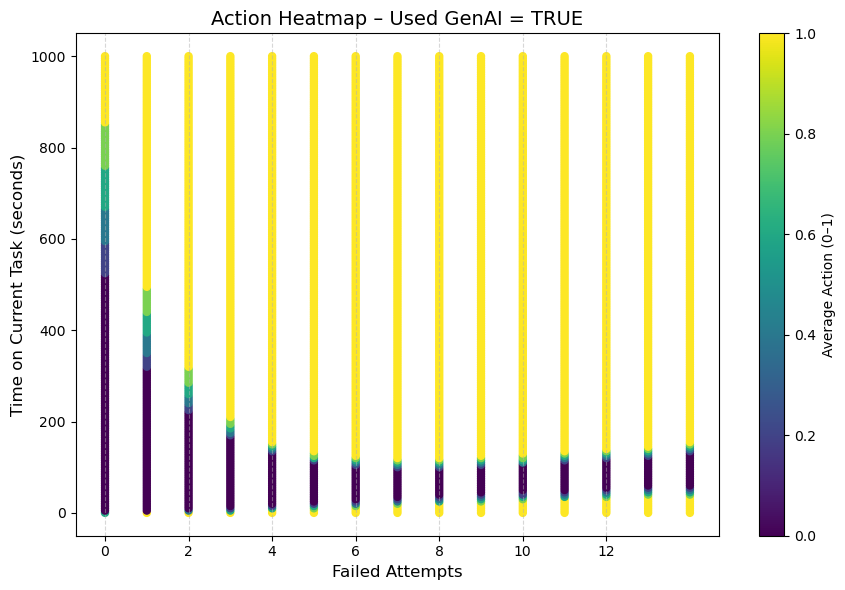

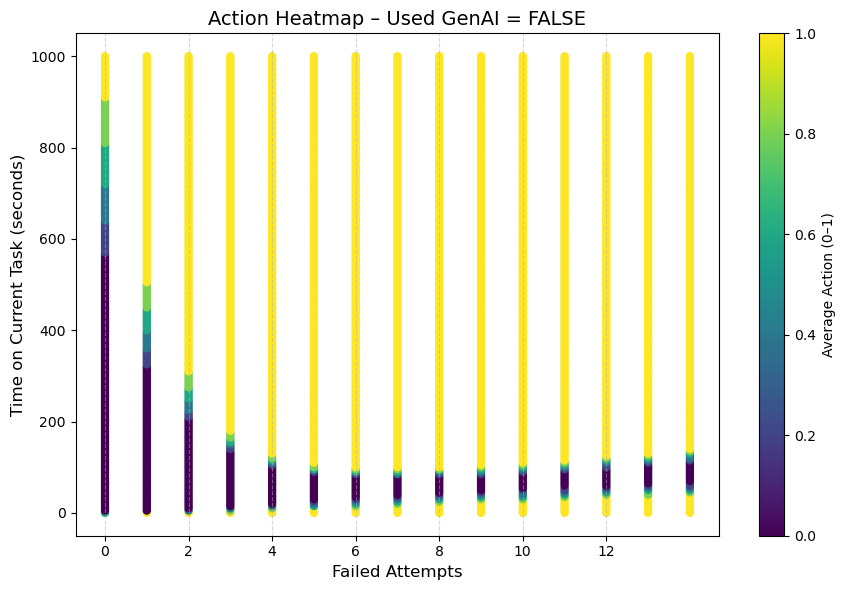

In [223]:
import numpy as np
import matplotlib.pyplot as plt

# Storage for plotting
data_true = []   # used_genai = 1
data_false = []  # used_genai = 0

for failed_attempts in range(0, 15):
    for time_on_task in range(0, 1001, 5):
        for used_GenAI in [0, 1]:
            actions = []
            for current_understanding in range(0, 5):
                # observation space
            # 1) Failed attempts on current task (0-20)
            # 2) Time on the current task in seconds (0-10000)
            # 3) Current understanding modeled as cummulative failed attempts on current metatask (0-60)
            # 4) Used GenAI on metatask 1 (0 or 1)
            # 5) Used GenAI on metatask 2 (0 or 1)
            # 6) Used GenAI on metatask 3 (0 or 1)
            # 7) Current metatask (0, 1, 2)

                obs = np.array(
                    [failed_attempts, time_on_task, current_understanding+failed_attempts, used_GenAI, 0, 0, 0, 1, 0], #assume we are in meatask 1 
                    dtype=np.float32
                )
                action, _ = model.predict(obs, deterministic=True)
                actions.append(action)

            mean_action = np.mean(actions)

            if used_GenAI == 1:
                data_true.append([failed_attempts, time_on_task, mean_action])
            else:
                data_false.append([failed_attempts, time_on_task, mean_action])

data_true = np.array(data_true)
data_false = np.array(data_false)

# ----------------------------------------------------
# Helper function for nice plot
# ----------------------------------------------------
def make_plot(data, title):
    plt.figure(figsize=(9, 6))
    
    sc = plt.scatter(
        data[:, 0],     # failed_attempts
        data[:, 1],     # time_on_task
        c=data[:, 2],   # mean_action
        vmin=0.0, #min color = 0
        vmax=1.0, #max color = 1
        s=25
    )
    
    plt.xlabel("Failed Attempts", fontsize=12)
    plt.ylabel("Time on Current Task (seconds)", fontsize=12)
    plt.title(title, fontsize=14)
    plt.xticks(np.arange(0, 14, 2))
    plt.grid(which="major", axis="x", linestyle="--", alpha=0.5)
    plt.colorbar(sc, label="Average Action (0–1)")
    plt.tight_layout()
    plt.show()

# ----------------------------------------------------
# Produce the two final plots
# ----------------------------------------------------
make_plot(data_true,  "Action Heatmap – Used GenAI = TRUE")
make_plot(data_false, "Action Heatmap – Used GenAI = FALSE")

In [224]:
#Helper function to update a dictionary that keeps track of sums and counts for each position in lists
def update_position_sums(counter_dict, new_list):
    for i, val in enumerate(new_list):
        if i not in counter_dict:
            counter_dict[i] = [0, 0]  #[sum, count]
        counter_dict[i][0] += val
        counter_dict[i][1] += 1

Running episodes: 100%|██████████| 200/200 [00:11<00:00, 17.10it/s]


{0: [0, 200], 1: [0, 200], 2: [0, 200], 3: [0, 200], 4: [0, 200], 5: [0, 200], 6: [0, 200], 7: [0, 200], 8: [0, 200], 9: [0, 200], 10: [0, 200], 11: [0, 200], 12: [0, 200], 13: [0, 200], 14: [0, 200], 15: [0, 200], 16: [0, 200], 17: [0, 200], 18: [0, 200], 19: [0, 200], 20: [0, 200], 21: [0, 200], 22: [0, 200], 23: [0, 200], 24: [0, 200], 25: [0, 200], 26: [0, 200], 27: [0, 200], 28: [0, 200], 29: [0, 200], 30: [0, 200], 31: [0, 200], 32: [0, 200], 33: [0, 200], 34: [0, 200], 35: [0, 200], 36: [0, 200], 37: [0, 200], 38: [0, 200], 39: [0, 200], 40: [0, 200], 41: [0, 200], 42: [0, 200], 43: [0, 200], 44: [0, 200], 45: [1, 200], 46: [1, 200], 47: [1, 200], 48: [1, 200], 49: [2, 200], 50: [2, 200], 51: [2, 200], 52: [1, 200], 53: [2, 200], 54: [1, 200], 55: [1, 200], 56: [1, 200], 57: [1, 200], 58: [2, 200], 59: [3, 200], 60: [3, 200], 61: [4, 200], 62: [5, 200], 63: [7, 200], 64: [5, 200], 65: [5, 200], 66: [7, 200], 67: [7, 200], 68: [10, 200], 69: [7, 200], 70: [5, 200], 71: [6, 200], 

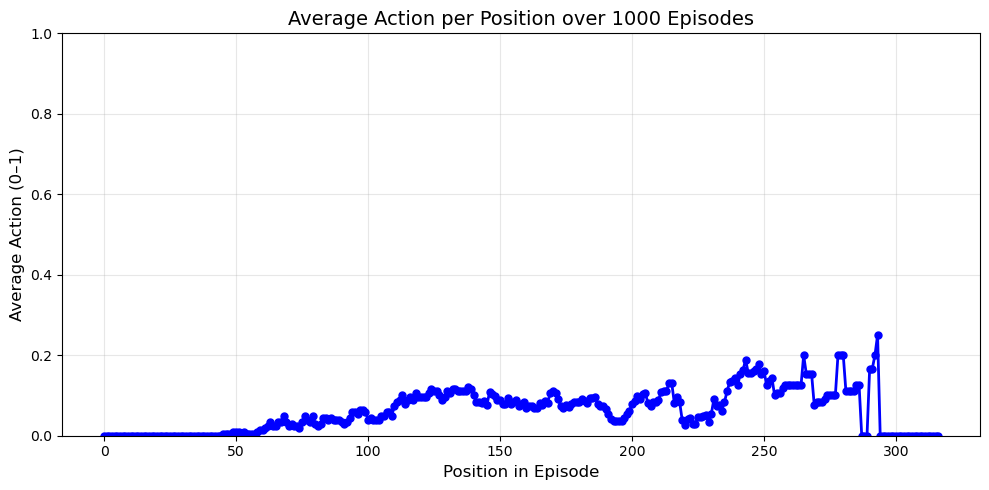

In [225]:
env = gym.make("MyEnv-v1")

num_episodes = 200
action_means_dict = {}

for ep in tqdm(range(num_episodes), desc="Running episodes"):
    obs, _ = env.reset()
    actions = []
    done = False

    while not done:
        action, _ = model.predict(obs, deterministic=True) #works for deterministic = false
        action = int(np.squeeze(action)) #ensure it's 0 or 1
        actions.append(action)    
        obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

    update_position_sums(action_means_dict, actions)

print(action_means_dict)

# Calculate and print average actions per position
average_actions = {pos: action_means_dict[pos][0] / action_means_dict[pos][1] for pos in action_means_dict}

# Sort positions to plot them in order
positions = sorted(average_actions.keys())
means = [average_actions[pos] for pos in positions]

plt.figure(figsize=(10,5))
plt.plot(positions, means, marker='o', linestyle='-', linewidth=2, markersize=5, color='blue')
plt.ylim(0, 1)  # actions are binary, so mean is between 0 and 1
plt.xlabel("Position in Episode", fontsize=12)
#plt.ylim(0,0.001)
plt.ylabel("Average Action (0–1)", fontsize=12)
plt.title("Average Action per Position over 1000 Episodes", fontsize=14)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

env.close()

In [238]:
#test what the model outputs for certain inputs
obs = np.array([ 10, 800, 0, 0, 0, 0, 1, 0, 0 ], #assume we are in meatask 1 
                dtype=np.float32)
action, _ = model.predict(obs, deterministic=True)
print(action)

1


### Save the model

We will primarily use use the onnx format (universal NN file format) for this which is eneugh for inference (cant train in JS but also not necessary).

In [227]:
#save the model
model.save("ppo_model")

In [246]:
import torch

# 1. Load your working model
model = PPO.load("ppo_model")
policy = model.policy.eval()

# 2. Create a Wrapper that mimics predict(deterministic=True)
class ActionPredictor(torch.nn.Module):
    def __init__(self, policy):
        super().__init__()
        self.policy = policy

    def forward(self, obs):
        # This is exactly what deterministic=True does inside SB3
        # It gets the distribution and takes the 'mode' (mean)
        features = self.policy.extract_features(obs)
        latent_pi, _ = self.policy.mlp_extractor(features)
        action_logits = self.policy.action_net(latent_pi)
        
        # For Discrete actions, we take the Argmax
        return torch.argmax(action_logits, dim=1)

# 3. Export the Wrapper instead of the raw policy
predictor = ActionPredictor(policy)
dummy_input = torch.randn(1, *model.observation_space.shape)

torch.onnx.export(
    predictor,
    dummy_input,
    "ppo_policy.onnx",
    input_names=["observation"],
    output_names=["action"],
    opset_version=12,
    dynamic_axes={"observation": {0: "batch_size"}, "action": {0: "batch_size"}}
)

In [250]:
#test if the model is correct
import onnxruntime as ort

# 1. Load the ONNX model
session = ort.InferenceSession("ppo_policy.onnx")

# 2. Prepare your input
# Your observation has 9 features. Ensure it matches the model's expected shape.
# PPO models usually expect a batch dimension: [Batch Size, Features]
obs = np.array([ 5, 250.084, 5, 0, 0, 0, 1, 0, 0 ], dtype=np.float32)
obs_batched = obs.reshape(1, -1) 

# 3. Run Inference
# The 'input_names' and 'output_names' must match your export script
inputs = {session.get_inputs()[0].name: obs_batched}
outputs = session.run(["action"], inputs)

# 4. Extract result
print(outputs)

[array([1])]


In [244]:
from stable_baselines3 import PPO

# Load the model
model = PPO.load("ppo_model")

# Now you can use it just like before
obs = np.array([10, 800, 0, 0, 0, 0, 1, 0, 0], dtype=np.float32)
action, _ = model.predict(obs, deterministic=True)
print(action)

1
